In [ ]:
#Run model on new video to detect the result

In [ ]:
!pip install mediapipe==0.10.11

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### PLANK TESTING

Extracted keypoints (same format as training):
            Keypoint         X         Y         Z
0               Nose  0.328899  0.224937  0.047037
1      Left Shoulder  0.308640  0.306550 -0.158650
2     Right Shoulder  0.332808  0.332340  0.244651
3         Left Elbow  0.223710  0.318470 -0.114091
4        Right Elbow  0.259108  0.349254  0.293659
5         Left Wrist  0.241804  0.239054  0.076113
6        Right Wrist  0.253125  0.271070  0.225480
7           Left Hip  0.251930  0.511683 -0.132852
8          Right Hip  0.269211  0.519564  0.132827
9          Left Knee  0.238324  0.710202 -0.117314
10        Right Knee  0.254583  0.696891  0.092147
11        Left Ankle  0.263422  0.888027 -0.081874
12       Right Ankle  0.277906  0.860952  0.140693
13         Left Heel  0.280780  0.911886 -0.081222
14        Right Heel  0.291826  0.888018  0.146003
15   Left Foot Index  0.218249  0.912429 -0.147519
16  Right Foot Index  0.235328  0.888884  0.118687

Model input format:
     Nose_x   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


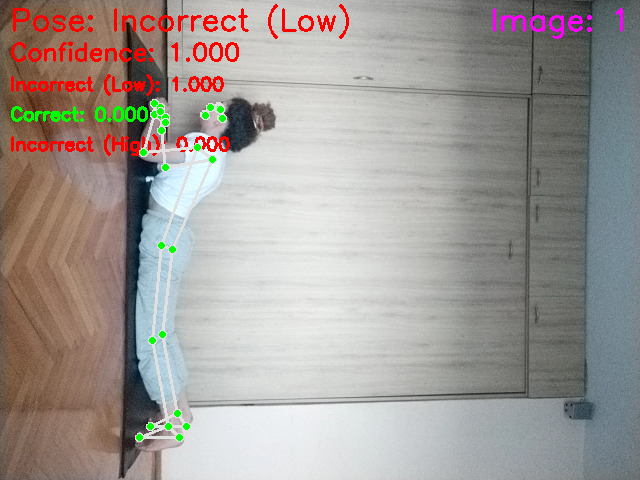

In [ ]:
#Image
import cv2
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import joblib
from mediapipe.framework.formats import landmark_pb2

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

keypoints_name = {
    "Nose": 0,
    "Left Shoulder": 11,
    "Right Shoulder": 12,
    "Left Elbow": 13,
    "Right Elbow": 14,
    "Left Wrist": 15,
    "Right Wrist": 16,
    "Left Hip": 23,
    "Right Hip": 24,
    "Left Knee": 25,
    "Right Knee": 26,
    "Left Ankle": 27,
    "Right Ankle": 28,
    "Left Heel": 29,
    "Right Heel": 30,
    "Left Foot Index": 31,
    "Right Foot Index": 32
}

def draw_results_on_image(frame, predictions, frame_num=1):
    annotated_frame = frame.copy()
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    class_labels = {0: "Incorrect (Low)", 1: "Correct", 2: "Incorrect (High)"}

    # Add prediction text
    cv2.putText(
        annotated_frame,
        f"Pose: {class_labels[predicted_class]}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Confidence: {confidence:.3f}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (Low): {predictions[0]:.3f}",
        (10, 90),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Correct: {predictions[1]:.3f}",
        (10, 120),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (High): {predictions[2]:.3f}",
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Image: {frame_num}",
        (annotated_frame.shape[1] - 150, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 255),
        2
    )
    return annotated_frame

# Load the trained .keras model and scaler
model_path = 'best_model.keras'
scaler_path = 'best_scaler1.pkl'
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize PoseLandmarker
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Image input setup
image_path = 'poza_1591810200563.jpg'
frame = cv2.imread(image_path)

if frame is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    # Detect pose landmarks
    detection_result = pose_landmarker.detect(mp_image)

    # Extract keypoints
    if detection_result.pose_landmarks:
        keypoints = []

        # Process ALL pose landmarks
        for pose_landmarks in detection_result.pose_landmarks:
            for keypoint_name, index in keypoints_name.items():
                landmark = pose_landmarks[index]
                keypoints.append([
                    keypoint_name,
                    landmark.x,
                    landmark.y,
                    landmark.z
                ])

        # Create DataFrame in the same format as training
        df = pd.DataFrame(keypoints, columns=["Keypoint", "X", "Y", "Z"])

        print("Extracted keypoints (same format as training):")
        print(df)

        # Create feature vector in consistent order
        keypoints_data = []
        for keypoint_name, index in keypoints_name.items():  # Same order as training
            # Find the row for this keypoint
            keypoint_row = df[df['Keypoint'] == keypoint_name].iloc[0]
            keypoints_data.extend([keypoint_row['X'], keypoint_row['Y'], keypoint_row['Z']])

        # Create single-row DataFrame for model input
        keypoints_df = pd.DataFrame([keypoints_data], columns=[
            f"{name}_{coord}" for name in keypoints_name.keys() for coord in ['x', 'y', 'z']
        ])

        print("\nModel input format:")
        print(keypoints_df)

        # Scale and predict
        x_test = scaler.transform(keypoints_df)
        x_test = x_test.reshape((1, x_test.shape[1], 1))

        # Debug info
        print(f"\nImage 1 - Raw keypoints shape: {np.array(keypoints_data).shape}")
        print(f"Image 1 - Scaled input shape: {x_test.shape}")
        print(f"Image 1 - Scaled input min/max: {x_test.min():.3f}/{x_test.max():.3f}")

        # Predict pose class
        predictions = model.predict(x_test, verbose=0)[0]
        annotated_frame = draw_results_on_image(frame, predictions)

        # Draw keypoints (rest of visualization code remains the same)
        landmark_list = landmark_pb2.NormalizedLandmarkList()
        for landmark in detection_result.pose_landmarks[0]:
            landmark_proto = landmark_list.landmark.add()
            landmark_proto.x = landmark.x
            landmark_proto.y = landmark.y
            landmark_proto.z = landmark.z

        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        mp_drawing.draw_landmarks(
            annotated_frame,
            landmark_list,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
        )
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

    else:
        annotated_frame = frame
        cv2.putText(
            annotated_frame,
            "No Pose Detected",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2
        )

    # Display the annotated image
    cv2_imshow(annotated_frame)

pose_landmarker.close()

In [ ]:
#VIDEO

import cv2
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import joblib
from mediapipe.framework.formats import landmark_pb2
from google.colab.patches import cv2_imshow

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

keypoints_name = {
    "Nose": 0,
    "Left Shoulder": 11,
    "Right Shoulder": 12,
    "Left Elbow": 13,
    "Right Elbow": 14,
    "Left Wrist": 15,
    "Right Wrist": 16,
    "Left Hip": 23,
    "Right Hip": 24,
    "Left Knee": 25,
    "Right Knee": 26,
    "Left Ankle": 27,
    "Right Ankle": 28,
    "Left Heel": 29,
    "Right Heel": 30,
    "Left Foot Index": 31,
    "Right Foot Index": 32
}

def draw_results_on_image(frame, predictions, frame_num=1):
    annotated_frame = frame.copy()
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    class_labels = {0: "Incorrect (Low)", 1: "Correct", 2: "Incorrect (High)"}

    # Add prediction text
    cv2.putText(
        annotated_frame,
        f"Pose: {class_labels[predicted_class]}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Confidence: {confidence:.3f}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (Low): {predictions[0]:.3f}",
        (10, 90),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Correct: {predictions[1]:.3f}",
        (10, 120),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (High): {predictions[2]:.3f}",
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Frame: {frame_num}",
        (annotated_frame.shape[1] - 150, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 255),
        2
    )
    return annotated_frame

def process_frame_keypoints(detection_result):
    """Extract keypoints from detection result in consistent format"""
    if not detection_result.pose_landmarks:
        return None, None

    # Use only the first pose (most confident detection)
    keypoints = []
    pose_landmarks = detection_result.pose_landmarks[0]

    for keypoint_name, index in keypoints_name.items():
        landmark = pose_landmarks[index]
        keypoints.append([
            keypoint_name,
            landmark.x,
            landmark.y,
            landmark.z
        ])

    # Create DataFrame in the same format as training
    df = pd.DataFrame(keypoints, columns=["Keypoint", "X", "Y", "Z"])

    # Convert to model input format
    keypoints_data = []
    for keypoint_name, index in keypoints_name.items():
        keypoint_row = df[df['Keypoint'] == keypoint_name].iloc[0]
        keypoints_data.extend([keypoint_row['X'], keypoint_row['Y'], keypoint_row['Z']])

    # Create single-row DataFrame for model input
    keypoints_df = pd.DataFrame([keypoints_data], columns=[
        f"{name}_{coord}" for name in keypoints_name.keys() for coord in ['x', 'y', 'z']
    ])

    return df, keypoints_df

# Load the trained .keras model and scaler
model_path = 'best_model.keras'
scaler_path = 'best_scaler1.pkl'
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize PoseLandmarker
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Video input setup
video_path = 'test.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video file or webcam.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video Info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

# Optional: Set up video writer to save output
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

frame_count = 0
correct_frames = 0
total_processed = 0

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video or failed to read frame")
            break

        frame_count += 1

        # Process every N frames for better performance (optional)
        # if frame_count % 2 != 0:  # Process every 2nd frame
        #     continue

        # Convert frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

        # Detect pose landmarks
        detection_result = pose_landmarker.detect(mp_image)

        # Process keypoints and predict
        if detection_result.pose_landmarks:
            df, keypoints_df = process_frame_keypoints(detection_result)

            if keypoints_df is not None:
                # Scale and predict
                x_test = scaler.transform(keypoints_df)
                x_test = x_test.reshape((1, x_test.shape[1], 1))

                # Predict pose class
                predictions = model.predict(x_test, verbose=0)[0]
                predicted_class = np.argmax(predictions)

                # Count correct poses
                if predicted_class == 1:  # Correct pose
                    correct_frames += 1

                total_processed += 1

                # Draw results on frame
                annotated_frame = draw_results_on_image(frame, predictions, frame_count)

                # Draw pose landmarks
                landmark_list = landmark_pb2.NormalizedLandmarkList()
                for landmark in detection_result.pose_landmarks[0]:
                    landmark_proto = landmark_list.landmark.add()
                    landmark_proto.x = landmark.x
                    landmark_proto.y = landmark.y
                    landmark_proto.z = landmark.z

                # Convert to RGB for drawing, then back to BGR
                annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
                mp_drawing.draw_landmarks(
                    annotated_frame,
                    landmark_list,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                )
                annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
            else:
                annotated_frame = frame
        else:
            # No pose detected
            annotated_frame = frame.copy()
            cv2.putText(
                annotated_frame,
                "No Pose Detected",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2
            )
            cv2.putText(
                annotated_frame,
                f"Frame: {frame_count}",
                (annotated_frame.shape[1] - 150, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 255),
                2
            )

        # Add overall statistics
        if total_processed > 0:
            accuracy_percent = (correct_frames / total_processed) * 100
            cv2.putText(
                annotated_frame,
                f"Correct Poses: {correct_frames}/{total_processed} ({accuracy_percent:.1f}%)",
                (10, annotated_frame.shape[0] - 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 255, 255),
                2
            )

        # Display the frame
        cv2_imshow(annotated_frame)

        # Optional: Write frame to output video
        # out.write(annotated_frame)

        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
            if total_processed > 0:
                print(f"Correct poses so far: {correct_frames}/{total_processed} ({(correct_frames/total_processed)*100:.1f}%)")

        # Break on 'q' key press - Not applicable in Colab
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     print("Video processing stopped by user")
        #     break

except KeyboardInterrupt:
    print("Video processing interrupted by user")

finally:
    # Final statistics
    print(f"\n=== Final Results ===")
    print(f"Total frames processed: {frame_count}")
    print(f"Frames with pose detected: {total_processed}")
    if total_processed > 0:
        accuracy = (correct_frames / total_processed) * 100
        print(f"Correct plank poses: {correct_frames}/{total_processed} ({accuracy:.2f}%)")
        print(f"Incorrect poses: {total_processed - correct_frames}/{total_processed} ({100-accuracy:.2f}%)")

    # Release everything
    cap.release()
    # out.release()  # Uncomment if saving video
    cv2.destroyAllWindows()
    pose_landmarker.close()

    print("Video processing completed!")

In [ ]:
# VIDEO

import cv2
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import joblib
from mediapipe.framework.formats import landmark_pb2
from google.colab.patches import cv2_imshow

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

keypoints_name = {
    "Nose": 0,
    "Left Shoulder": 11,
    "Right Shoulder": 12,
    "Left Elbow": 13,
    "Right Elbow": 14,
    "Left Wrist": 15,
    "Right Wrist": 16,
    "Left Hip": 23,
    "Right Hip": 24,
    "Left Knee": 25,
    "Right Knee": 26,
    "Left Ankle": 27,
    "Right Ankle": 28,
    "Left Heel": 29,
    "Right Heel": 30,
    "Left Foot Index": 31,
    "Right Foot Index": 32
}

def draw_results_on_image(frame, predictions, frame_num=1):
    """Draw results on frame - always in readable orientation"""
    annotated_frame = frame.copy()
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    class_labels = {0: "Incorrect (Low)", 1: "Correct", 2: "Incorrect (High)"}

    # Main pose result
    cv2.putText(
        annotated_frame,
        f"Pose: {class_labels[predicted_class]}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Confidence: {confidence:.3f}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (Low): {predictions[0]:.3f}",
        (10, 90),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Correct: {predictions[1]:.3f}",
        (10, 120),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (High): {predictions[2]:.3f}",
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Frame: {frame_num}",
        (annotated_frame.shape[1] - 150, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 255),
        2
    )
    return annotated_frame

def add_statistics_text(frame, correct_frames, total_processed):
    """Add statistics text to frame"""
    if total_processed > 0:
        accuracy_percent = (correct_frames / total_processed) * 100
        cv2.putText(
            frame,
            f"Correct Poses: {correct_frames}/{total_processed} ({accuracy_percent:.1f}%)",
            (10, frame.shape[0] - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            2
        )
    return frame

def process_frame_keypoints(detection_result):
    """Extract keypoints from detection result in consistent format"""
    if not detection_result.pose_landmarks:
        return None, None

    # Use only the first pose (most confident detection)
    keypoints = []
    pose_landmarks = detection_result.pose_landmarks[0]

    for keypoint_name, index in keypoints_name.items():
        landmark = pose_landmarks[index]
        keypoints.append([
            keypoint_name,
            landmark.x,
            landmark.y,
            landmark.z
        ])

    # Create DataFrame in the same format as training
    df = pd.DataFrame(keypoints, columns=["Keypoint", "X", "Y", "Z"])

    # Convert to model input format
    keypoints_data = []
    for keypoint_name, index in keypoints_name.items():
        keypoint_row = df[df['Keypoint'] == keypoint_name].iloc[0]
        keypoints_data.extend([keypoint_row['X'], keypoint_row['Y'], keypoint_row['Z']])

    # Create single-row DataFrame for model input
    keypoints_df = pd.DataFrame([keypoints_data], columns=[
        f"{name}_{coord}" for name in keypoints_name.keys() for coord in ['x', 'y', 'z']
    ])

    return df, keypoints_df

# Load the trained .keras model and scaler
model_path = 'best_model.keras'
scaler_path = 'best_scaler1.pkl'
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize PoseLandmarker
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Video input setup
video_path = 'test2.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video file or webcam.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video Info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

# Set up video writer to save output (rotated dimensions)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_height, frame_width))  # Swapped width and height for rotation

frame_count = 0
correct_frames = 0
total_processed = 0

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video or failed to read frame")
            break

        frame_count += 1

        # Convert frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

        # Detect pose landmarks
        detection_result = pose_landmarker.detect(mp_image)

        # Process keypoints and predict
        predictions = None
        if detection_result.pose_landmarks:
            df, keypoints_df = process_frame_keypoints(detection_result)

            if keypoints_df is not None:
                # Scale and predict (convert to numpy array to avoid sklearn warning)
                x_test = scaler.transform(keypoints_df.values)  # .values converts DataFrame to numpy array
                x_test = x_test.reshape((1, x_test.shape[1], 1))

                # Predict pose class
                predictions = model.predict(x_test, verbose=0)[0]
                predicted_class = np.argmax(predictions)

                # Count correct poses
                if predicted_class == 1:  # Correct pose
                    correct_frames += 1

                total_processed += 1

                # Draw pose landmarks on frame
                landmark_list = landmark_pb2.NormalizedLandmarkList()
                for landmark in detection_result.pose_landmarks[0]:
                    landmark_proto = landmark_list.landmark.add()
                    landmark_proto.x = landmark.x
                    landmark_proto.y = landmark.y
                    landmark_proto.z = landmark.z

                # Draw landmarks
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_drawing.draw_landmarks(
                    frame,
                    landmark_list,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                )
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Create display frame with text (for cv2_imshow)
        if predictions is not None:
            display_frame = draw_results_on_image(frame, predictions, frame_count)
        else:
            display_frame = frame.copy()
            cv2.putText(
                display_frame,
                "No Pose Detected",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2
            )
            cv2.putText(
                display_frame,
                f"Frame: {frame_count}",
                (display_frame.shape[1] - 150, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 255),
                2
            )

        # Add statistics to display frame
        display_frame = add_statistics_text(display_frame, correct_frames, total_processed)

        # Display the frame (normal orientation)
        cv2_imshow(display_frame)

        # For output video: Rotate frame FIRST, then add text
        rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Add text AFTER rotation (so text is readable)
        if predictions is not None:
            rotated_frame = draw_results_on_image(rotated_frame, predictions, frame_count)
        else:
            cv2.putText(
                rotated_frame,
                "No Pose Detected",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2
            )
            cv2.putText(
                rotated_frame,
                f"Frame: {frame_count}",
                (rotated_frame.shape[1] - 150, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 255),
                2
            )

        # Add statistics to rotated frame
        rotated_frame = add_statistics_text(rotated_frame, correct_frames, total_processed)

        # Write rotated frame with readable text to output video
        out.write(rotated_frame)

        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
            if total_processed > 0:
                print(f"Correct poses so far: {correct_frames}/{total_processed} ({(correct_frames/total_processed)*100:.1f}%)")

except KeyboardInterrupt:
    print("Video processing interrupted by user")

finally:
    # Final statistics
    print(f"\n=== Final Results ===")
    print(f"Total frames processed: {frame_count}")
    print(f"Frames with pose detected: {total_processed}")
    if total_processed > 0:
        accuracy = (correct_frames / total_processed) * 100
        print(f"Correct plank poses: {correct_frames}/{total_processed} ({accuracy:.2f}%)")
        print(f"Incorrect poses: {total_processed - correct_frames}/{total_processed} ({100-accuracy:.2f}%)")

    # Release everything
    cap.release()
    out.release()  # Release the video writer
    cv2.destroyAllWindows()
    pose_landmarker.close()

    print("Video processing completed!")
    print("Output video saved as 'output_video.mp4'")

## HOLDING SQUAT

In [ ]:
# VIDEO

import cv2
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import joblib
from mediapipe.framework.formats import landmark_pb2
from google.colab.patches import cv2_imshow

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

keypoints_name = {
    "Nose": 0,
    "Left Shoulder": 11,
    "Right Shoulder": 12,
    "Left Elbow": 13,
    "Right Elbow": 14,
    "Left Wrist": 15,
    "Right Wrist": 16,
    "Left Hip": 23,
    "Right Hip": 24,
    "Left Knee": 25,
    "Right Knee": 26,
    "Left Ankle": 27,
    "Right Ankle": 28
}

def draw_results_on_image(frame, predictions, frame_num=1):
    """Draw results on frame - always in readable orientation"""
    annotated_frame = frame.copy()
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    class_labels = {0: "Incorrect (Low)", 1: "Correct", 2: "Incorrect (High)"}

    # Main pose result
    cv2.putText(
        annotated_frame,
        f"Pose: {class_labels[predicted_class]}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Confidence: {confidence:.3f}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0) if predicted_class == 1 else (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (Low): {predictions[0]:.3f}",
        (10, 90),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Correct: {predictions[1]:.3f}",
        (10, 120),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Incorrect (High): {predictions[2]:.3f}",
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
    cv2.putText(
        annotated_frame,
        f"Frame: {frame_num}",
        (annotated_frame.shape[1] - 150, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 255),
        2
    )
    return annotated_frame

def add_statistics_text(frame, correct_frames, total_processed):
    """Add statistics text to frame"""
    if total_processed > 0:
        accuracy_percent = (correct_frames / total_processed) * 100
        cv2.putText(
            frame,
            f"Correct Poses: {correct_frames}/{total_processed} ({accuracy_percent:.1f}%)",
            (10, frame.shape[0] - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            2
        )
    return frame

def process_frame_keypoints(detection_result):
    """Extract keypoints from detection result in consistent format"""
    if not detection_result.pose_landmarks:
        return None, None

    # Use only the first pose (most confident detection)
    keypoints = []
    pose_landmarks = detection_result.pose_landmarks[0]

    for keypoint_name, index in keypoints_name.items():
        landmark = pose_landmarks[index]
        keypoints.append([
            keypoint_name,
            landmark.x,
            landmark.y,
            landmark.z
        ])

    # Create DataFrame in the same format as training
    df = pd.DataFrame(keypoints, columns=["Keypoint", "X", "Y", "Z"])

    # Convert to model input format
    keypoints_data = []
    for keypoint_name, index in keypoints_name.items():
        keypoint_row = df[df['Keypoint'] == keypoint_name].iloc[0]
        keypoints_data.extend([keypoint_row['X'], keypoint_row['Y'], keypoint_row['Z']])

    # Create single-row DataFrame for model input
    keypoints_df = pd.DataFrame([keypoints_data], columns=[
        f"{name}_{coord}" for name in keypoints_name.keys() for coord in ['x', 'y', 'z']
    ])

    return df, keypoints_df

# Load the trained .keras model and scaler
model_path = 'best_model_squat.keras'
scaler_path = 'best_scaler_squat.pkl'
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize PoseLandmarker
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Video input setup
video_path = 'test5.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video file or webcam.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video Info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

# Set up video writer to save output (rotated dimensions)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_height, frame_width))  # Swapped width and height for rotation

frame_count = 0
correct_frames = 0
total_processed = 0

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video or failed to read frame")
            break

        frame_count += 1

        # Convert frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

        # Detect pose landmarks
        detection_result = pose_landmarker.detect(mp_image)

        # Process keypoints and predict
        predictions = None
        if detection_result.pose_landmarks:
            df, keypoints_df = process_frame_keypoints(detection_result)

            if keypoints_df is not None:
                # Scale and predict (convert to numpy array to avoid sklearn warning)
                x_test = scaler.transform(keypoints_df.values)  # .values converts DataFrame to numpy array
                x_test = x_test.reshape((1, x_test.shape[1], 1))

                # Predict pose class
                predictions = model.predict(x_test, verbose=0)[0]
                predicted_class = np.argmax(predictions)

                # Count correct poses
                if predicted_class == 1:  # Correct pose
                    correct_frames += 1

                total_processed += 1

                # Draw pose landmarks on frame
                landmark_list = landmark_pb2.NormalizedLandmarkList()
                for landmark in detection_result.pose_landmarks[0]:
                    landmark_proto = landmark_list.landmark.add()
                    landmark_proto.x = landmark.x
                    landmark_proto.y = landmark.y
                    landmark_proto.z = landmark.z

                # Draw landmarks
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_drawing.draw_landmarks(
                    frame,
                    landmark_list,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                )
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Create display frame with text (for cv2_imshow)
        if predictions is not None:
            display_frame = draw_results_on_image(frame, predictions, frame_count)
        else:
            display_frame = frame.copy()
            cv2.putText(
                display_frame,
                "No Pose Detected",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2
            )
            cv2.putText(
                display_frame,
                f"Frame: {frame_count}",
                (display_frame.shape[1] - 150, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 255),
                2
            )

        # Add statistics to display frame
        display_frame = add_statistics_text(display_frame, correct_frames, total_processed)

        # Display the frame (normal orientation)
        cv2_imshow(display_frame)

        # For output video: Rotate frame FIRST, then add text
        rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Add text AFTER rotation (so text is readable)
        if predictions is not None:
            rotated_frame = draw_results_on_image(rotated_frame, predictions, frame_count)
        else:
            cv2.putText(
                rotated_frame,
                "No Pose Detected",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2
            )
            cv2.putText(
                rotated_frame,
                f"Frame: {frame_count}",
                (rotated_frame.shape[1] - 150, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 255),
                2
            )

        # Add statistics to rotated frame
        rotated_frame = add_statistics_text(rotated_frame, correct_frames, total_processed)

        # Write rotated frame with readable text to output video
        out.write(rotated_frame)

        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
            if total_processed > 0:
                print(f"Correct poses so far: {correct_frames}/{total_processed} ({(correct_frames/total_processed)*100:.1f}%)")

except KeyboardInterrupt:
    print("Video processing interrupted by user")

finally:
    # Final statistics
    print(f"\n=== Final Results ===")
    print(f"Total frames processed: {frame_count}")
    print(f"Frames with pose detected: {total_processed}")
    if total_processed > 0:
        accuracy = (correct_frames / total_processed) * 100
        print(f"Correct plank poses: {correct_frames}/{total_processed} ({accuracy:.2f}%)")
        print(f"Incorrect poses: {total_processed - correct_frames}/{total_processed} ({100-accuracy:.2f}%)")

    # Release everything
    cap.release()
    out.release()  # Release the video writer
    cv2.destroyAllWindows()
    pose_landmarker.close()

    print("Video processing completed!")
    print("Output video saved as 'output_video.mp4'")